In [5]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

raw_df = pd.read_hdf('./data/merged_data.h5')


In [6]:
selected_sample_id = 1207
df = raw_df[raw_df.sample_id == selected_sample_id].copy().reset_index(drop=True)

In [7]:
df = df.drop(columns = ['sample_id', 'time', 'coin_index'])

In [9]:
column_indices = {name : i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [10]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

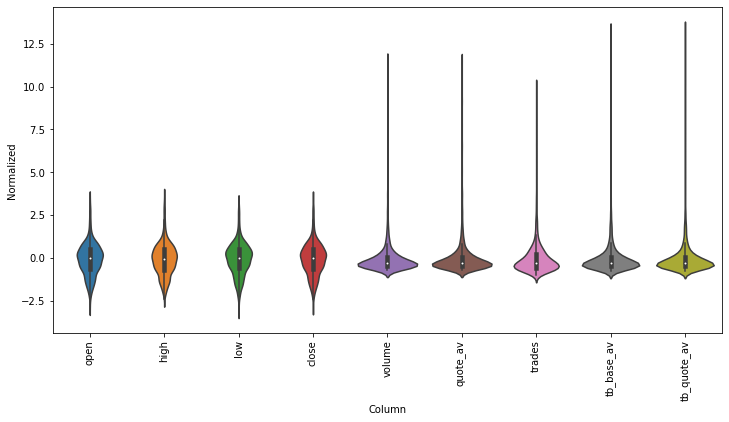

In [11]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [12]:
class WindowGenerator():
    
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns

        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [13]:
w1 = WindowGenerator(input_width=24, label_width=3, shift=24,
                     label_columns=['open'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [45 46 47]
Label column name(s): ['open']

In [14]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['open'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['open']

In [15]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [16]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
labels shape: (3, 1, 1)


In [17]:
w2.example = example_inputs, example_labels

In [49]:
def plot(self, model=None, plot_col='open', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]

    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()

    plt.xlabel('Time [min]')

WindowGenerator.plot = plot

tf.Tensor(
[[[-1.2960393  -1.3234347  -1.1729338  ... -0.5685455  -0.18926588
   -0.19209756]
  [-1.2727824  -1.3740283  -1.3976914  ... -0.5573144  -0.52642596
   -0.5275151 ]
  [-1.5345769  -1.5890895  -1.4867955  ... -0.6864722  -0.46658403
   -0.46827495]
  [-1.6179713  -1.7089763  -1.5670747  ... -0.7594744  -0.5712687
   -0.5723601 ]
  [-1.7037698  -1.8200892  -1.7677639  ... -0.41692552 -0.56802225
   -0.56926715]
  [-1.7414516  -1.7145488  -1.6625971  ... -0.3383078  -0.13447298
   -0.13869047]]

 [[-0.1774534  -0.20071979 -0.1173056  ... -0.43938777  0.09090418
    0.09004849]
  [-0.09687237 -0.23097096 -0.11329421 ... -0.2709211  -0.03852317
   -0.03912453]
  [-0.19709566 -0.33093873 -0.20239837 ... -0.5236211   0.03469969
    0.03360773]
  [-0.3089645  -0.4368856  -0.2004012  ...  0.0154722   0.04106288
    0.03991924]
  [-0.30413917 -0.4368856  -0.30114695 ... -0.6471633  -0.3043496
   -0.30481416]
  [-0.37992898 -0.47154063 -0.32120392 ... -0.46185    -0.35979348
   -0.360

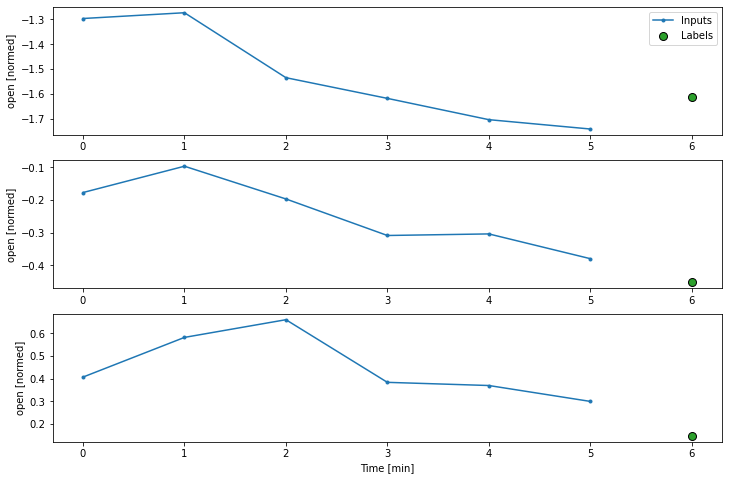

In [38]:
w2.plot(plot_col = 'open')

In [20]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [21]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['open'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['open']

In [25]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 9)
Labels shape (batch, time, features): (32, 1, 1)


In [27]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [28]:
baseline = Baseline(label_index=column_indices['open'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

10/10 [==============================] - 0s 1ms/step - loss: 0.0350 - mean_absolute_error: 0.1344


In [29]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['open'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['open']

In [41]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)
print('------------------------------------------------')
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 1, 9)
Output shape: (32, 1, 1)
------------------------------------------------
Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


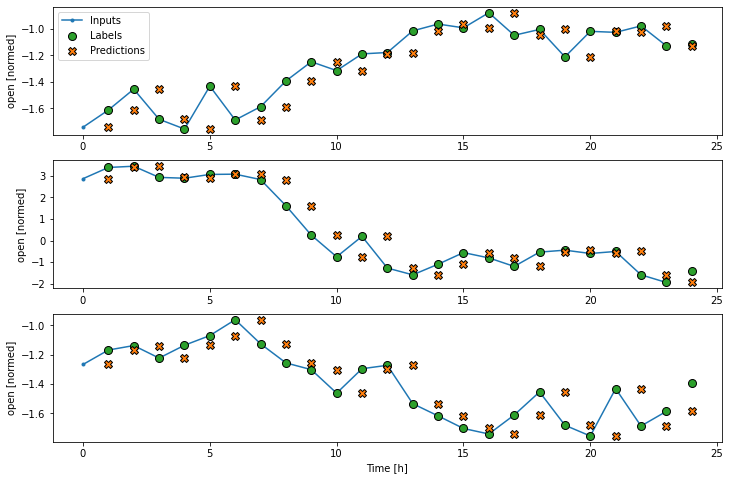

In [31]:
wide_window.plot(baseline, plot_col='open')

In [43]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [44]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 9)
Output shape: (32, 1, 1)


In [45]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [46]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
33/33 [==============================] - 1s 16ms/step - loss: 5.1474 - mean_absolute_error: 1.7841 - val_loss: 3.3750 - val_mean_absolute_error: 1.4081
Epoch 2/20
33/33 [==============================] - 0s 6ms/step - loss: 4.9680 - mean_absolute_error: 1.7358 - val_loss: 2.9852 - val_mean_absolute_error: 1.3215
Epoch 3/20
33/33 [==============================] - 0s 5ms/step - loss: 4.2196 - mean_absolute_error: 1.6004 - val_loss: 2.6422 - val_mean_absolute_error: 1.2413
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 3.7806 - mean_absolute_error: 1.5181 - val_loss: 2.3218 - val_mean_absolute_error: 1.1618
Epoch 5/20
33/33 [==============================] - 0s 5ms/step - loss: 3.3127 - mean_absolute_error: 1.4066 - val_loss: 2.0420 - val_mean_absolute_error: 1.0876
Epoch 6/20
33/33 [==============================] - 0s 5ms/step - loss: 2.7813 - mean_absolute_error: 1.3095 - val_loss: 1.7843 - val_mean_absolute_error: 1.0156
Epoch 7/20
33/33 [=========

In [47]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 9)
Output shape: (32, 24, 1)


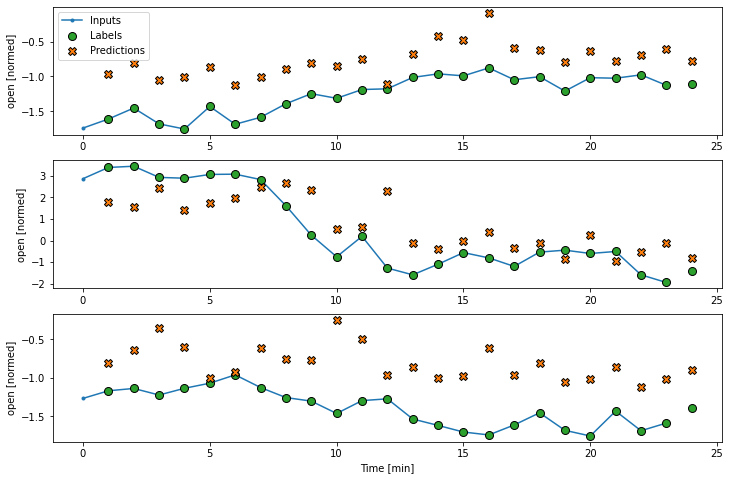

In [51]:
wide_window.plot(linear)

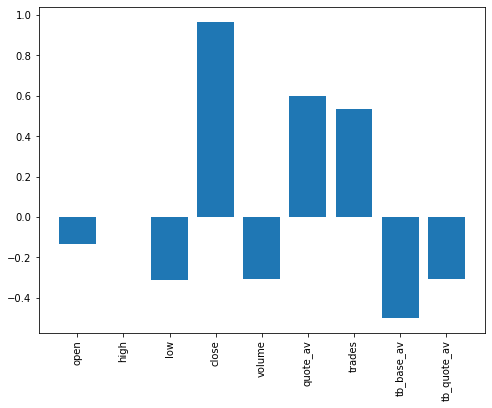

In [52]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [53]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
33/33 [==============================] - 1s 16ms/step - loss: 0.6867 - mean_absolute_error: 0.5758 - val_loss: 0.0294 - val_mean_absolute_error: 0.1307
Epoch 2/20
33/33 [==============================] - 0s 6ms/step - loss: 0.0366 - mean_absolute_error: 0.1415 - val_loss: 0.0150 - val_mean_absolute_error: 0.0929
Epoch 3/20
33/33 [==============================] - 0s 6ms/step - loss: 0.0246 - mean_absolute_error: 0.1076 - val_loss: 0.0100 - val_mean_absolute_error: 0.0734
Epoch 4/20
33/33 [==============================] - 0s 6ms/step - loss: 0.0169 - mean_absolute_error: 0.0879 - val_loss: 0.0078 - val_mean_absolute_error: 0.0635
Epoch 5/20
33/33 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0716 - val_loss: 0.0085 - val_mean_absolute_error: 0.0675
Epoch 6/20
33/33 [==============================] - 0s 6ms/step - loss: 0.0085 - mean_absolute_error: 0.0633 - val_loss: 0.0052 - val_mean_absolute_error: 0.0518
Epoch 7/20
33/33 [=========

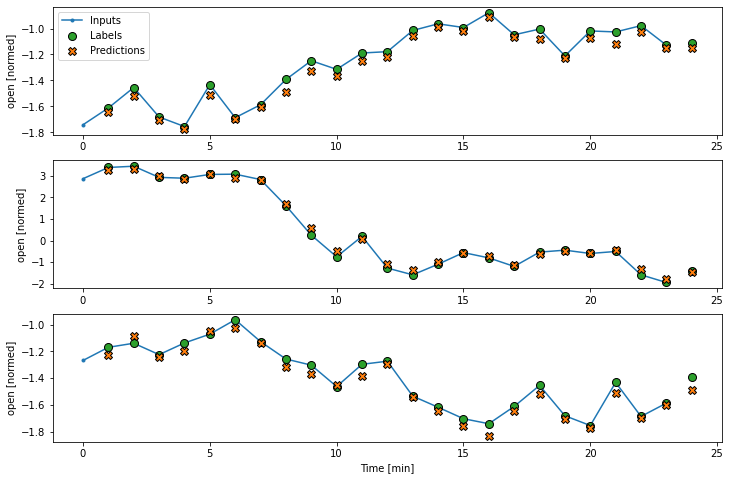

In [54]:
wide_window.plot(dense)